In [1]:
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.utils import save_image
import torchvision.models as tvmodels
from torchvision import datasets, transforms

import segmentation_models_pytorch as smp

import numpy as np

import matplotlib.pyplot as plt

sys.path.insert(0, "../src")
import exlib
from exlib.explainers import *
from exlib.modules import *
from exlib.datasets.abdomen_organs import *

In [2]:
DATA_DIR = "/home/antonxue/foo/data/abdomen_exlib/"
train_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="train")
test_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="test")

In [3]:
state_dict = torch.load("/home/antonxue/foo/real_drs/saved_models/weiqiu_model2.pt")

In [5]:
model = AbdomenSegModel(num_segments=3, in_channels=3)
# model.unet = smp.Unet(
#         encoder_name = "resnet50",
#         encoder_weights = "imagenet",
#         in_channels = 3,
#         classes = 3,
#         activation = "softmax2d"
#     )
# model.unet.load_state_dict(state_dict["model_state_dict"])
model.unet.eval()
model.eval();

In [15]:
x, olabel, glabel = test_dataset[0]
# y = model(x[None,...])
olabel.shape, glabel.shape

(torch.Size([1, 384, 640]), torch.Size([1, 384, 640]))

In [19]:
omasks = F.one_hot(olabel[0], num_classes=4).permute(2,0,1)
gmasks = F.one_hot(glabel[0], num_classes=3).permute(2,0,1)
omasks.shape, gmasks.shape

(torch.Size([4, 384, 640]), torch.Size([3, 384, 640]))

In [31]:
x_organ0 = x * omasks[0]
x_organ1 = x * omasks[1]
x_organ2 = x * omasks[2]
x_organ3 = x * omasks[3]

x_organs = (0 * omasks[0]) + (80 * omasks[1]) + (160 * omasks[2]) + (240 * omasks[3])

<Figure size 640x480 with 0 Axes>

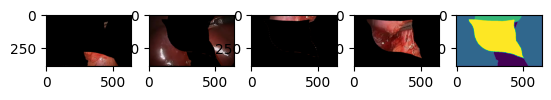

In [32]:
plt.figure()
fig, ax = plt.subplots(1,5)
ax[0].imshow(x_organ0.numpy().transpose(1,2,0))
ax[1].imshow(x_organ1.numpy().transpose(1,2,0))
ax[2].imshow(x_organ2.numpy().transpose(1,2,0))
ax[3].imshow(x_organ3.numpy().transpose(1,2,0))
ax[4].imshow(x_organs.numpy())

In [35]:
x_gng0 = x * gmasks[0]
x_gng1 = x * gmasks[1]
x_gng2 = x * gmasks[2]
x_gngs = (0 * gmasks[0]) + (120 * gmasks[1]) + (240 * gmasks[2])

<Figure size 640x480 with 0 Axes>

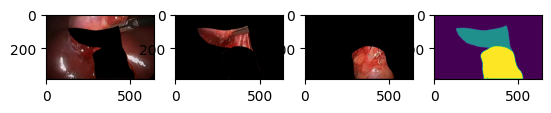

In [36]:
plt.figure()
fig, ax = plt.subplots(1,4)
ax[0].imshow(x_gng0.numpy().transpose(1,2,0))
ax[1].imshow(x_gng1.numpy().transpose(1,2,0))
ax[2].imshow(x_gng2.numpy().transpose(1,2,0))
ax[3].imshow(x_gngs.numpy())

In [ ]:
# Dump stuff

In [45]:
filename = test_dataset.image_filenames[0]
saveto_dir = "/home/antonxue/foo/test/dump/"

In [52]:
save_image(x, f"{saveto_dir}/{filename}")

save_image(x_organ0, f"{saveto_dir}/{filename}_organ0.png")
save_image(x_organ1, f"{saveto_dir}/{filename}_organ1.png")
save_image(x_organ2, f"{saveto_dir}/{filename}_organ2.png")
save_image(x_organ3, f"{saveto_dir}/{filename}_organ3.png")
save_image(x_organs / 255., f"{saveto_dir}/{filename}_organs.png")

save_image(x_gng0, f"{saveto_dir}/{filename}_gng0.png")
save_image(x_gng1, f"{saveto_dir}/{filename}_gng1.png")
save_image(x_gng2, f"{saveto_dir}/{filename}_gng2.png")
save_image(x_gngs / 255., f"{saveto_dir}/{filename}_gngs.png")